# Exercises

## 4th order Runge-Kutta ODE integration

For any system of 1st order differential equations:

$$ \frac{dy}{dt} = f(t, y), $$

the RK4 method is one of the most popular approaches. 
Note that we can here also think of $y$ as a vector!

From page 246 of our text we have 
1. We compute first

$$ k_1=h\, f(t_i, y_i) $$

2. The get the slope at the midpoint using Eulers method to predict $y_{i+1/2}$:

$$ k_2 = h\,f(t_i+h/2, y_i+k_1/2) $$

3. The improved slope at the midpoint is used to further improve the slope of $y_{i+1/2}$ by:

$$ k_3 = h\, f(t_i+h/2, y_i+k_2/2) $$

4. Using this improved slope we can predict $y_{i+1}$ using

$$k_4 = h\, f(t_i+h, y_i + k_3) $$

5. The weighted combination of these slopes gives the final update step:

$$ y_{i+1} = y_i + \frac{1}{6} (k_1 + 2k_2+2k_3 +k_4) $$

This is the most popular of a large class of methods. 
In this case our book gives the derivation and also the [Wikipedia article](http://en.wikipedia.org/wiki/Runge–Kutta_methods") is rather useful.


Implement this RK4 scheme and follow the lecture to show the convergence rate of this solver. 
Submit the full code.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def HarmOsc(t, y, w0 = 1.0, damp = 0):
    return np.array([y[1], - w0**2 * y[0] - w0 * damp * y[1]])

In [3]:
def RK4Step(f, h, ti, yi, damp):
    k1 = h * f(ti, yi, damp = damp)
    k2 = h * f(ti + h/2, yi + k1/2, damp = damp)
    k3 = h * f(ti + h/2, yi + k2/2, damp = damp)
    k4 = h * f(ti + h, yi + k3, damp = damp)
    return yi + (k1 + 2*k2 + 2*k3 + k4)/6

In [4]:
def SolveHarmOscRK4(tfinal, h, w0, phase, damp):
    N = int(tfinal/h)
    h = tfinal/N

    x = np.zeros(N)
    v = np.zeros(N)
    
    x[0] = np.cos(0 + phase)
    v[0] = -w0 * np.sin(0 + phase)

    for i in tqdm(range(1,N)):
        x[i], v[i] = RK4Step(HarmOsc, h, i*h, np.array([x[i-1], v[i-1]]), damp)
    t = np.arange(N)*h
    return x,v,t

In [5]:
from scipy.optimize import fsolve

In [6]:
def findInit(w0, phase, damp=0):
    lambd = w0*damp/2
    w1 = w0*np.sqrt(1-damp**2/4)
    return fsolve(lambda x: np.array([x[0] * np.cos(x[1]) - np.cos(phase), x[0] * w1 * np.sin(x[1]) + x[0] * lambd * np.sin(x[1]) - w0 * np.sin(phase)]), np.array([1, 1]))

In [7]:
def SolveHarmOscAnalytic(tfinal, h, w0, phase, damp=0):
    lambd = w0*damp/2
    w1 = w0*np.sqrt(1-damp**2/4)
    x0 = np.cos(phase)
    v0 = -w0*np.sin(phase)
    A, phi = findInit(w0, phase, damp)

    N = int(tfinal/h)
    h = tfinal/N
    t = np.arange(N)*h
    x = A * np.cos(w1*t + phi) * np.exp(-lambd*t)
    v = -A * (w1 * np.sin(w1*t+phi) + lambd*np.cos(w1*t+phi)) * np.exp(-lambd*t)
    return x, v, t

In [8]:
def HarmRunner(solver, h=1.0, tfinal=2*2.0*np.pi, w0=1.0, phase=1.0, damp=0):
    x, v, t = solver(tfinal, h, w0, phase, damp)
    analytic_x, analytic_v, analytic_t = SolveHarmOscAnalytic(tfinal, h, w0, phase, damp)
    
    plt.figure(figsize=(10,5))
        
    plt.subplot(1,2,1)
    plt.plot(t, analytic_x,'r')
    plt.plot(t, x,'x-',alpha=.4)
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.legend(['analytic', 'numerical'], loc='best')
    
    plt.subplot(1,2,2)
    plt.plot(analytic_x, analytic_v, 'r')
    plt.plot(x, v,'kx-',alpha=.4)
    plt.xlabel('x(t)')
    plt.ylabel('v(t)')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.legend(['analytic', 'numerical'], loc='best')

100%|██████████| 124/124 [00:00<00:00, 24652.50it/s]


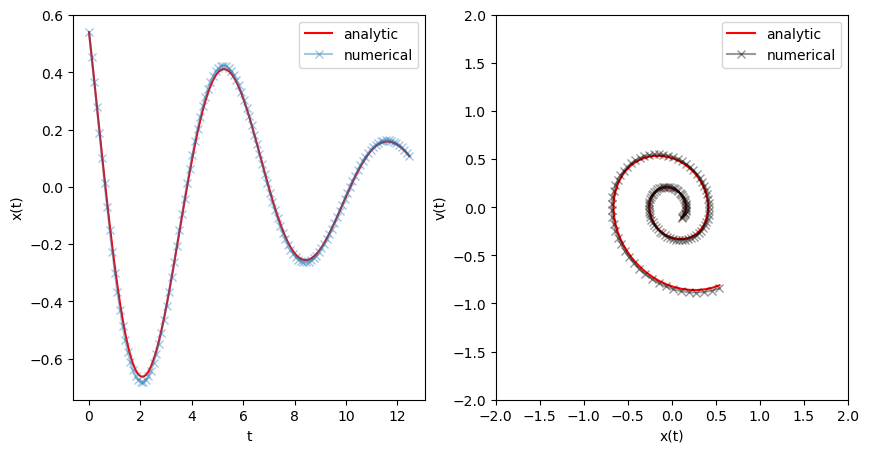

In [9]:
HarmRunner(SolveHarmOscRK4, h=0.1, tfinal=2*2.0*np.pi, w0=1.0, phase=1.0, damp = 0.3)

In [10]:
def energy(x, v, w0):
    return 0.5*w0**2*x**2 + 0.5*v**2

def dE(x, v, w0, Energy):
    e = energy(x, v, w0)
    de = np.fabs(e - Energy)
    return de
    
def L2(y, ye):
    """Compute the L2 error norm on two input arrays. One approximate the other exact"""
    return np.sqrt(((y[1:-1] - ye[1:-1])**2).sum()/(ye[1:-1]**2).sum()) # ignore initial condition

In [11]:
tfinal = 2*2.*np.pi
w0 = 1
phase = 1

# Set up a list of step sizes
hs = np.logspace(0, -3, 5)

"""
# Set up a Python Dictionary to store all of our Solvers
Solvers = {
           'Euler': SolveHarmOscEuler,
           'Back-Euler': SolveHarmOscEulerBackward,
           'Heun': SolveHarmOscHeun,
           'Numerov': SolveHarmOscNumerov,
           'Leap-Frog': SolveHarmOscLeapFrog,
           'Verlet' : SolveHarmOscVerlet,
           'Hermite': SolveHarmOscHermite,
           'RK4'    : SolveHarmOscRK4,
           'Yoshida': SolveHarmOscYoshida
           }"""
Solvers = {'RK4': SolveHarmOscRK4}

for key, value in Solvers.items():
    print(key, value)


RK4 <function SolveHarmOscRK4 at 0x0000012D03D82170>


In [12]:
Ns = np.empty(len(hs), dtype='int')

# Now use a Python Dictionary to store our test results
L2_errors = {} # This is a dictionary

for key in Solvers.keys():
    L2_errors[key] = np.zeros_like(hs, dtype='float64')
    
for i, h in enumerate(hs):
    analytic_x, analytic_v, analytic_t = SolveHarmOscAnalytic(tfinal, h, w0, phase)
    Ns[i] = int(tfinal/h)
    for key, solver in Solvers.items():
        x, v, t = solver(tfinal, h, w0, phase)
        L2_errors[key][i] = L2(x,analytic_x)

TypeError: SolveHarmOscRK4() missing 1 required positional argument: 'damp'

In [ ]:
print(('Steps     ', [N for N in Ns]))
for key, value in L2_errors.items():
    print ((key + '       ')[:10], ['%0.2e' % val for val in value])

('Steps     ', [12, 70, 397, 2234, 12566])
RK4        ['6.58e-02', '5.77e-05', '5.69e-08', '5.72e-11', '5.76e-14']


C:\Users\danie\AppData\Local\Temp\ipykernel_26876\2248002137.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(Ns, Ns.astype('float64')**(-2)*1e2, '-', label=r'$\propto N{^-2}$', ls='--', lw=3.0)


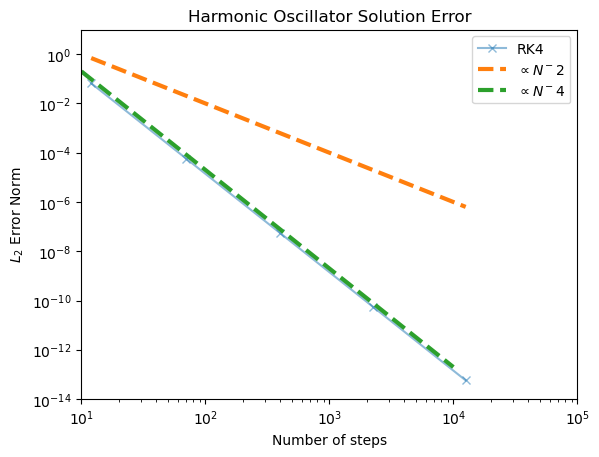

In [ ]:
for solver, l2 in L2_errors.items():
    p = plt.loglog(Ns, l2, marker='x', alpha=0.5, label=solver)

plt.loglog(Ns, Ns.astype('float64')**(-2)*1e2, '-', label=r'$\propto N{^-2}$', ls='--', lw=3.0)
plt.loglog(10.**(np.arange(4)+1),(10.**(np.arange(4)+1))**(-4)*2e3, label=r'$\propto N{^-4}$',ls='--', lw=3.0)
plt.legend(loc='best')
plt.xlabel('Number of steps')
plt.ylabel('$L_2$ Error Norm')
plt.title('Harmonic Oscillator Solution Error')
plt.ylim((1e-14,1e1));
plt.xlim((1e1,1e5));

In [ ]:
h = 0.001
tfinal = 10.0
solution = {}
for solver_name, solver in Solvers.items():
    solution[solver_name] = solver(tfinal, h, w0, phase)
solution['Analytic'] = SolveHarmOscAnalytic(tfinal, h, w0, phase)

100%|██████████| 9999/9999 [00:00<00:00, 32278.16it/s]


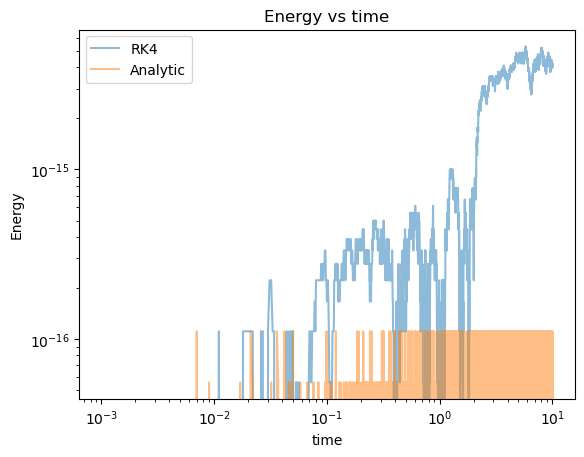

In [ ]:
from numpy import fabs
Energy = .5 # w0*w0/2 * x[0]*x[0] +  va[0]*va[0]/2;

for solver, (x, v, t) in solution.items():
    plt.loglog(t, dE(x, v, w0, Energy), label=solver, alpha=.5)

plt.title('Energy vs time')
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend(loc='best');